# Imports and package set-up

In [1]:
import os
import pickle

from itertools import chain
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import tensorflow as tf

from hyperopt import fmin, tpe, hp, Trials
from tensorflow.keras import activations, layers, optimizers, regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.constraints import max_norm
from scipy.optimize import minimize

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # should shut TF up a bit
sns.set()
np.set_printoptions(threshold=256)
rc = {
    "font.family": "serif",
    "mathtext.fontset": "stix",
    "figure.dpi": 100,
    "figure.figsize": [9, 5],
    "font.serif": ["Charter"] + plt.rcParams["font.serif"],
    # 'text.usetex': True,
    # 'text.latex.preamble': [r'\usepackage{amsmath}']
}
plt.rcParams.update(rc)

# Simulate

In [3]:
class SimulateData(object):
    def __init__(self, situation, n, one_hot=True, seed=None, equi_distant=False):
        self.situation = situation
        self.n = n
        if seed is not None: 
            np.random.seed(seed)  # note: assuming samplig with np
        self.seed = seed
        
        self.X, self.funcs = self.situational_stuff(equi_distant)
        self.d = 1 if self.X[0].ndim == 0 else self.X[0].shape
        self.K = len(self.funcs)
        
        self.f_X = np.array([f(self.X) for f in self.funcs]).T
        self.Y_prob = np.array([self.f_X[i] / x_sum for i, x_sum in enumerate(self.f_X.sum(axis=1))])
        
        if one_hot: self.Y_one_hot = self.one_hot_from_Y_probs()
        
    def unif_rejection_sampling(self, p):
        # Rejection sampling from density function p; proposal is unif[0, 1].
        # MAYDO: faster sampling method.
        q_pdf = ss.uniform().pdf
        q_sample = np.random.uniform
    
        grid = np.linspace(0, 1, 1000)
        m = max(p(grid)) * 1.3  # should divide by q_pdf(grid) but that's always 1.
        # The 1.3 factor is just to be sure m * q > p. Proportion accepted ~ 1/m.
    
        X = []
        while len(X) < self.n:
            z = q_sample()
            if np.random.uniform(0, m * q_pdf(z)) <= p(z):
                X.append(z)
        return np.array(X)
    
    def situational_stuff(self, equi_distant=False):
        # Default:
        X = np.random.uniform(size=self.n) if not equi_distant else np.linspace(0, 1, self.n)
        
        if self.situation == "Simple 1D":
            def f1(X): return (1 + X) / 3
            def f2(X): return (2 - X) / 3
            return X, [f1, f2] 
        
        if self.situation == "Simple 2D":
            # desc = f"Situation 2: sampling {n} X_i ~ 2D uniforms. f1(X) = sum(X) / 2. K = 2."
            X1 = np.random.uniform(size=self.n)
            X2 = np.random.uniform(size=self.n)
            X = np.column_stack([X1, X2])
            def f1(X): return (X[:, 0] + X[:, 1]) / 2
            def f2(X): return 1 - f1(X)
            return X, [f1, f2]
        
        if "x^" in self.situation:
            # TODO again probably, this string stuff
            r_str = self.situation.split('^')[1].split(' ')[0]
            r = int(r_str) if r_str.isdigit() else 5
            
            # Allow doing something linear after specified b, default to 1
            b_str = self.situation.split('b=')[1].split(' ')[0] if "b=" in self.situation else "not a valid float"
            b = float(b_str) if b_str[0] in ["0", "."] else 1
            br = b ** r
            def f1(X): return np.array([br + X_i - b if X_i > b else X_i ** r for X_i in X])
            def f2(X): return br + 1 - b - f1(X)
            return X, [f1, f2]
        
        if self.situation == "Mixture of uniforms":
            # TODO: parametrize in that string.
            a = [0.05, .55]
            b = [.45, .95]
            pY = [.5,.5]
    
            def p(x):
                return sum([ss.uniform(a[i], b[i]).pdf(x) * pY[i] for i in range(len(pY))])
    
            X = self.unif_rejection_sampling(p)
            def f1(X): return 1 / (1 + np.power(X / (1 - X), - 1 * 3))
            def f2(X): return 1 - f1(X)
            return X, [f1, f2]   
        
        if "sin(" in self.situation:
            more = self.situation.split('+1')
            m = float(more[1]) if len(more[1]) > 1 else 0
            def f1(X): return (np.sin(2 * np.math.pi * X) + 1 + m) / 2
            # Or Taylor approximation
            # TODO: get maxx from situation string
            if "Taylor" in self.situation:
                def f1(X, maxx = 10):
                    xx = (X - .75)
                    s = 2 * np.math.pi ** 2 * xx ** 2 - 8 * np.math.pi ** 4 * xx ** 4
                    print(s)
                    return s
                    # Xp = 2 * np.math.pi * X
                    # return 1 + m + sum([(-1) ** (i+1) * Xp ** (2*i-1) / np.math.factorial(2*i-1) 
                    #                           for i in range(1, maxx)])
            def f2(X): return 1 + m - f1(X)
            return X, [f1, f2]

        if "sigmoid" in self.situation:
            beta = 4
            def f1(X): return 1 / (1 + np.power(X / (1 - X), - 1 * beta))
            def f2(X): return 1 - f1(X)
            return X, [f1, f2]
        
        else:
            raise ValueError("Situation not implemented.")
    
    def one_hot_from_Y_probs(self):
        # Assign sample to category with a categorical probability.
        Y_cat = np.array([np.random.choice(self.K, 1, p=p) for p in self.Y_prob])
        return np.eye(self.K)[Y_cat.reshape(-1,)]
        
    def visualize(self, save_to_pdf=False):
        # TODO: a savefig option
        print("Euclidean distance between non- and normalized:", np.linalg.norm(self.f_X - self.Y_prob))

        t_space = np.geomspace(1e-20, 1, 10_000)  # denser where small.
        p_X_smaller = [np.mean(self.Y_prob <= t) for t in t_space]

        if self.X.ndim > 2:
            print("$\mathbf{X}$ dimensionality too high to visualize.")
            return -1
        
        plt.figure(); plt.xlabel("$x$"); plt.ylabel("Probability"); plt.ylim(0, 1.05)
        if self.X.ndim == 1:
            plt.plot(t_space, p_X_smaller, color='red', label='$\mathrm{\mathbb{P}}(\mathbf{p}_0(X) \leq x)$')
            # plt.plot(t_space, t_space, '--', alpha=.3, color='red')
            x, _, p = plt.hist(self.X, bins=30, density=True, alpha=.3, 
                               label='Scaled empirical density of $X_1, \ldots, X_n$')
            # Histogram scaling:
            for item in p: item.set_height(item.get_height() / max(x))
            
            # Empirical function plotting:
            order = np.argsort(self.X)
            for i in range(self.Y_prob.shape[1]):
                plt.plot(self.X[order], self.Y_prob[order, i], label=f'Normalized $p^0_{i+1}(x)$')
    
            plt.legend()
        elif self.X.ndim == 2:
            plt.plot(t_space, p_X_smaller, color='red', label='$\mathrm{\mathbb{P}}(\mathbf{p}_0(\mathbf{X}) \leq x)$')
            x, _, p = plt.hist(self.X, bins=30, density=True, alpha=.3,
                               label=[f'Scaled density of $X_{j+1}$ realizations' for j in range(self.X.shape[1])])
            for j in range(self.X.ndim):
                for item in p[j]:
                    item.set_height(item.get_height() / max(x[j]))
            
            plt.legend(); plt.show()

            # New 3D plot:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")
    
            subset = np.random.choice(self.X.shape[0], 200)
            for i in range(self.Y_prob.shape[1]):
                ax.scatter(self.X[subset, 0], self.X[subset, 1], self.Y_prob[subset, i],
                           label=f'$p^0_{i+1}(\mathbf{{x}})$')
            ax.set_xlabel('$x_1$')
            ax.set_ylabel('$x_2$')
            ax.legend()
        
        if save_to_pdf:
            plt.tight_layout()
            plt.savefig(f'Pictures/sim{self.seed}.pdf', format='pdf')
        else:
            plt.show()

# sit = "Taylor sin(2*pi*x)+1+.05"
# seed = 1
# tr = SimulateData(sit, 8192, seed=seed)
# tr.visualize()

# Network stuff

In [4]:
class KerasModelStuff(object):
    def __init__(self, train, val, hidden_widths=[24, 24, 24], l1=.0002):
        self.train = train
        self.val = val

        if self.train.X.ndim == 1:
            # Maybe TODO: copy the data if modifying it.
            self.train.X = self.train.X.reshape(-1, 1)
            self.val.X = self.val.X.reshape(-1, 1)

        self.model = self.initialize_model(hidden_widths, l1)
        self.history = None
        self.seed = None

    def initialize_model(self, hidden_widths, l1):
        # ReLU activations for hidden layers, softmax without weights before output.
        # Force _some_ sparsity. Note: not the same as theory (yet).

        norm = max_norm(1.0) # TODO: check (easy but need some results)

        m = [self.train.X[0].shape, *hidden_widths, self.train.K]
        model = tf.keras.models.Sequential(name=f'L-is-{len(hidden_widths)}-and-p_0-is-{m[0][0]}...')

        model.add(Dense(m[1], input_shape=m[0], name=f'p_0->p_1',
                        kernel_regularizer=regularizers.l1(l1),
                        bias_regularizer=regularizers.l1(l1),
                        kernel_constraint=norm, bias_constraint=norm))
        for i in range(2, len(m)):
            model.add(Dense(m[i], activation='relu', name=f'p_{i-1}->p_{i}',
                      kernel_regularizer=regularizers.l1(l1),
                      bias_regularizer=regularizers.l1(l1),
                      kernel_constraint=norm, bias_constraint=norm))
        model.add(layers.Activation(activations.softmax))
        return model
    
    def train_network(self, opt='adam', stop=.002, viz=0, seed=None):
        if seed is not None:
            tf.random.set_seed(seed)
            self.seed = seed

        if viz > 1: print(self.model.summary())
        self.model.compile(opt, 'categorical_crossentropy')
        
        cb = [tf.keras.callbacks.EarlyStopping('loss', min_delta=stop, patience=10, 
                                               verbose=viz, restore_best_weights=True)]
        bs = np.max([round(self.train.n / 512), 4])
        self.history = self.model.fit(self.train.X, self.train.Y_one_hot, epochs=120, callbacks=cb,
                                      validation_data=(self.val.X, self.val.Y_one_hot),
                                      batch_size=bs, use_multiprocessing=True, 
                                      verbose=0 if viz < 2 else 2, shuffle=False)

        if viz > 0:
            pd.DataFrame(self.history.history).plot()
            plt.gca().set_ylim(0, max(1, np.quantile(self.history.history['val_loss'], .98)))
            plt.grid(True); plt.xlabel('Epoch'); plt.show()

    def KL_trunc_loss(self, true, pred, B, minimum=1e-4):
        # Ugly and slow to make it transparent, bc I'm not sure.
        divergences = []
        for i, true_vec_i in enumerate(true):
            pred_vec_i = pred[i]
            current_sum = 0
            for k, true_i_k in enumerate(true_vec_i):
                pred_i_k = pred_vec_i[k]
                if pred_i_k < minimum:
                    current_sum += true_i_k * B
                else:
                    current_sum += true_i_k * np.minimum(B, np.log(true_i_k / pred_i_k))
            divergences.append(current_sum)
        return np.mean(divergences)

    def get_sparsity(self, epsilon=.001):
        W = self.model.get_weights()
        nz_biases = biases = nz_weights = weights = over_one = 0
        for i, W_i in enumerate(W):
            over_one += np.count_nonzero(W_i > 1)
            if i % 2 == 0:
                nz_weights += np.count_nonzero(W_i > epsilon)
                weights += W_i.size
            else:
                nz_biases += np.count_nonzero(W_i > epsilon)
                biases += W_i.size
        return {
            f"Biases > {epsilon}": nz_biases, "Biases total": biases,
            f"Weights > {epsilon}": nz_weights, "Weights total": weights,
            "s": nz_biases + nz_weights, "Weights and biases > 1": over_one
        }
    
    def KL_prob_val_loss(self):
        return tf.keras.losses.KLDivergence()(self.val.Y_prob, self.model.predict(self.val.X)).numpy().mean()

    def evaluate(self, test, B=1.5, visualize=True, save_to_pdf=False, loss_only=False):
        p = self.model.predict(test.X)
        t = test.Y_prob
        
        if visualize:
            if self.train.d == 1:
                plt.figure(); plt.xlabel("$x$"); plt.ylabel("Probability"); plt.ylim(0, 1.05)
                x, _, items = plt.hist(self.train.X, bins=30, density=True, alpha=.3, 
                                    label='Scaled density of $X$ (train) realizations')
                # Histogram scaling:
                for item in items:
                    item.set_height(item.get_height() / max(x))
                testX = test.X[:, 0] if test.X.ndim == 2 else test.X  # undo annoying reshape trick
                order = np.argsort(testX)
                for k in range(self.train.K):
                    plt.plot(testX[order], test.Y_prob[order, k], label=f'$p^0_{k+1}(x)$')
                    plt.plot(testX[order], p[order, k], '--', label=f'$\hat{{p}}_{k+1}(x)$',
                             color=plt.gca().lines[-1].get_color())
                plt.legend()
                if save_to_pdf:
                    plt.tight_layout()
                    plt.savefig(f'Pictures/eval{self.train.seed}_{self.seed}.pdf', format='pdf')
                else:
                    plt.show()
            # TODO: insert 2D here (I have it somewhere below)
            else:
                print("$\mathbf{X}$ dimensionality too high to visualize.")

        train_ll = tf.keras.losses.categorical_crossentropy(self.train.Y_one_hot, 
                                                            self.model.predict(self.train.X)).numpy().mean()
        losses = {
            "LL": tf.keras.losses.categorical_crossentropy(t, p).numpy().mean(),
            "MSE": tf.keras.losses.MeanSquaredError()(t, p).numpy(),
            "KL": tf.keras.losses.KLDivergence()(t, p).numpy().mean(),
            f"KL_B={B}": self.KL_trunc_loss(t, p, B),
            # Can't use history for training loss since we use early stopping:
            "Training LL": train_ll,
            "KL_val": self.KL_prob_val_loss()
        }
        if loss_only:
            return losses
        else:
            return {**losses, **self.get_sparsity(), 
                    "Pr. max difference": np.amax(np.abs(t - p)), 
                    'Train seed': self.train.seed, 'Network seed': self.seed}

# Actual experiments

In [6]:
def get_hw(n, m_star, L_star, optimizing=False):
    L = round(np.log2(n) *  L_star)
    if optimizing:  # just the way hyperopt works
        L += 2
    return [round(n ** m_star) for _ in range(L)]

def opt_network(situation, n, evals=50, opt_repeats=2, viz=0):
    param_space = {
        'L_star': 2 + hp.randint('L_star', 4),
        'm_star': hp.uniform('m_star', .05, .7),
        'lr': hp.uniform('lr', 0.0001, 0.0008),
        'l1': hp.uniform('l1', 0.0001, 0.001),
    }
    print(f"Searching for optimal {param_space.keys()} in {evals} attempts.")
    print(f"We're in situation {situation} with {n} samples.")

    def obj(params):
        hw = get_hw(n, params['m_star'], params['L_star'], optimizing=True)
        opt = optimizers.Adam(params['lr'])
        
        # Try a few trainings, return the best:
        # TODO: continue retraining if too bad
        train = SimulateData(situation, n)  # there's no default seed, so this is random
        val = SimulateData(situation, 10**4)
        KLs = []
        for _ in range(opt_repeats):
            kn = KerasModelStuff(train, val, hidden_widths=hw, l1=params['l1'])
            kn.train_network(opt=opt)
            KLs.append(kn.KL_prob_val_loss())
        if viz > 0:
            print(f"{KLs} with {params}")
        return np.min(KLs)

    filename = f"{HYPEROPT_FOLDER}{situation}__{n}.hyperopt"
    try: 
        trials = pickle.load(open(filename, "rb"))
        if evals <= len(trials.trials):
            trials.vals
            losses = np.asarray(trials.losses(), dtype=float)
            best_i = np.argmin(losses)
            best_params = {key: values[best_i] for key, values in trials.vals.items()}
            print("Already did", len(trials.trials), ">=", evals, "trials")
            return best_params, trials
        print(f"Found {len(trials.trials)} trials, so doing {evals - len(trials.trials)}.")
    except:
        if evals == 0:
            raise ValueError(f'evals == 0 and no {filename} found.')
        print(f"{filename} not found, starting trials from scratch.")
        trials = Trials()

    tpe_best = fmin(fn=obj, space=param_space, algo=tpe.suggest, max_evals=evals, trials=trials)
    with open(filename, "wb") as f:
        pickle.dump(trials, f)

    return tpe_best, trials

def evaluate_params(situation, n, test, n_repeats, n_retrains=5, opt_evals=10, params=None, viz=0):
    filename = f"{LOSS_FOLDER}{situation}__{n}.pkl"
    try: 
        results_pkl = pickle.load(open(filename, "rb"))
    except:
        results_pkl = defaultdict(list)
    n_found = len(results_pkl['KL'])

    assert test.situation == situation

    if params is None:
        params, _ = opt_network(situation, n, opt_evals, n_retrains)

    print(f"\n{situation, n} -- evaluating on test max(0, {n_repeats}-{n_found}) ", 
          f"time(s) with learning rate {params['lr']}, L1 penalty {params['l1']},")
    hw = get_hw(n, params['m_star'], params['L_star'])
    print('and hidden layers', hw)
    opt = optimizers.Adam(params['lr'])
    for i in range(n_found, np.max([n_found, n_repeats])):
        train = SimulateData(situation, n, seed=i)
        val = SimulateData(situation, 10**4)    
        KLs = []
        networks = []
        # TODO: continue retraining if too bad
        for j in range(n_retrains):
            km = KerasModelStuff(train, val, hidden_widths=hw, l1=params['l1'])
            km.train_network(opt=opt, seed=j)
            networks.append(km)
            KLs.append(km.KL_prob_val_loss())

        best_km = networks[np.argmin(KLs)]
        results_i = best_km.evaluate(test)
        for key in results_i.keys():
            results_pkl[key].append(results_i[key])
        # Maydo: store params as well
        
        # Backup every time
        with open(filename, "wb") as f:
            pickle.dump(results_pkl, f)
    
    return results_pkl

In [18]:
n_repeats = 10
n_retrains = 3  # will do more trainings later
opt_evals = 2
viz = 1
params = {'l1': 0.0002, 'lr': 0.00035, 'L_star': 0.3, 'm_star': 0.4}
# params = None

situation_list = ['sin(2*pi*x)+1', 'sin(2*pi*x)+1.2']
n_list = [1024, 1536, 2048, 3072, 4096, 8192]
for n in n_list:
    print(n, get_hw(n, params['m_star'], params['L_star']))

1024 [16, 16, 16]
1536 [19, 19, 19]
2048 [21, 21, 21]
3072 [25, 25, 25]
4096 [28, 28, 28, 28]
8192 [37, 37, 37, 37]


In [16]:
COLAB = 'google.colab' in str(get_ipython())
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive/',)
    %cd /content/drive/MyDrive/Thesis/

LOSS_FOLDER = './test_losses/'
HYPEROPT_FOLDER = './new_hyperopt/'
TEST_SEED = 1337

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Thesis


In [20]:
for i, situation in enumerate(situation_list):
    test = SimulateData(situation, 10**5, seed=TEST_SEED)
    for j, n in enumerate(n_list):
        results_pkl = evaluate_params(situation, n, test, n_repeats, n_retrains, opt_evals, params)
        print(results_pkl)

Output hidden; open in https://colab.research.google.com to view.

In [19]:
def redo(situation, n, params, factor=1.5):
    # TODO switch to val_KL key, needs a rerun of all evaluations :(
    test = SimulateData(situation, 10**5)
    filename = f"{LOSS_FOLDER}{situation}__{n}.pkl"
    results_pkl = pickle.load(open(filename, "rb"))

    # Redo terrible runs compared to the median
    kl_results = results_pkl['KL']
    n_runs = len(kl_results)
    assert n_runs > 2 # need some runs to compare to
    median_val_loss = np.median(kl_results)
    print(s, n, kl_results, 'threshold', factor * median_val_loss)

    test = None
    hw = get_hw(n, params['m_star'], params['L_star'])
    opt = optimizers.Adam(params['lr'])
    for i, loss in enumerate(kl_results):
        if loss > factor * median_val_loss:
            print(f'Retraining on training set with seed {i}')
            train = SimulateData(situation, n, seed=i)
            val = SimulateData(situation, 10**4)
            if test is None:
                test = SimulateData(situation, 10**5, TEST_SEED)
            j = n_runs
            while loss > factor * median_val_loss:
                j += 1
                km = KerasModelStuff(train, val, hidden_widths=hw, l1=params['l1'])
                km.train_network(opt=opt, seed=j)
                loss = km.KL_prob_val_loss()

            results_j = km.evaluate(test)
            # print(results_pkl)
            for key in results_j.keys():
                results_pkl[key][i] = results_j[key]
            # print(results_pkl)
            
    # Backup new file
    with open(filename, "wb") as f:
        pickle.dump(results_pkl, f)

for s in situation_list:
    for n in n_list:
        redo(s, n, params)

sin(2*pi*x)+1 1024 [0.06323554, 0.057710156, 0.065332085, 0.0663928, 0.07469896, 0.077478975, 0.08712072, 0.082111135, 0.08137461, 0.088610604] threshold 0.11413344740867615
sin(2*pi*x)+1 1536 [0.060989823, 0.0687126, 0.05191664, 0.07525042, 0.04576705, 0.07137203, 0.07541595, 0.06164416, 0.061389394, 0.06990437] threshold 0.09776756912469864
sin(2*pi*x)+1 2048 [0.041289303, 0.051841408, 0.03479538, 0.044843886, 0.04516796, 0.055326216, 0.03871065, 0.039762396, 0.045100905, 0.05542032] threshold 0.06745859608054161
sin(2*pi*x)+1 3072 [0.039668422, 0.036065597, 0.033669338, 0.046966217, 0.033944126, 0.041123398] threshold 0.056800514459609985
sin(2*pi*x)+1 4096 [0.011070036, 0.01687897, 0.013693307, 0.014351933] threshold 0.021033930592238903
sin(2*pi*x)+1 8192 [0.015445277, 0.0112816235, 0.008996343, 0.013101272] threshold 0.0182871725410223
sin(2*pi*x)+1.2 1024 [0.028673701, 0.045265775, 0.034484196, 0.043922402] threshold 0.058804951608181
sin(2*pi*x)+1.2 1536 [0.032648586, 0.0366421

Some visualization only stuff (local.py is probably more up-to-date)

defaultdict(<class 'list'>, {'KL': [0.021918086, 0.022239156, 0.024355095, 0.056265566, 0.03332349, 0.048209686, 0.055111703, 0.051792946, 0.042926632, 0.051463995, 0.016001327, 0.019632682, 0.049901374, 0.015860036, 0.040049054], 'LL': [0.40845007, 0.40877116, 0.41088703, 0.44279754, 0.41985542, 0.43531358, 0.4417497, 0.4384309, 0.42956457, 0.43810195, 0.40249458, 0.40612596, 0.43765062, 0.40360925, 0.42779824], 'MSE': [0.003997443, 0.0054255505, 0.004865882, 0.013519088, 0.008078317, 0.010510831, 0.013302026, 0.013040503, 0.010314026, 0.012404148, 0.0034571395, 0.0049800966, 0.012155814, 0.0026629432, 0.009097529], 'KL_B=1.5': [0.0219180879874477, 0.02223915735967679, 0.024355095847798703, 0.056265565706313275, 0.03332349041542601, 0.046751644689440756, 0.05511170712317309, 0.05179294865309681, 0.04292663106372308, 0.051464002012839266, 0.016001328163599147, 0.019632682442546397, 0.049901374555942304, 0.015860037096724892, 0.040049051095845285], 'Training LL': [0.433227, 0.40838438, 

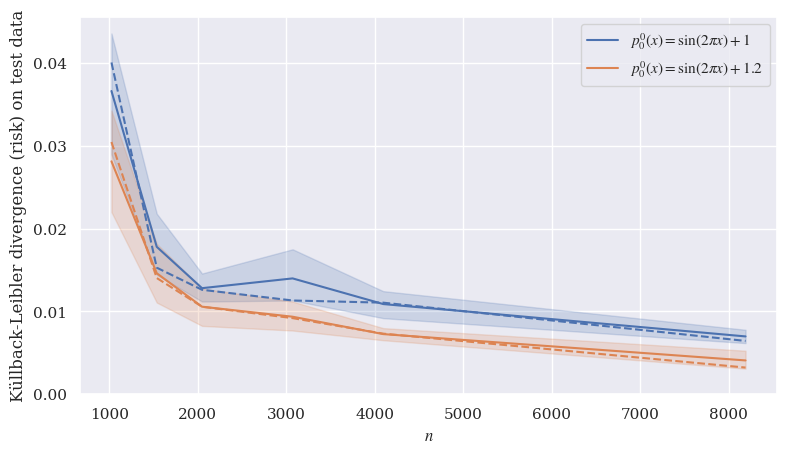

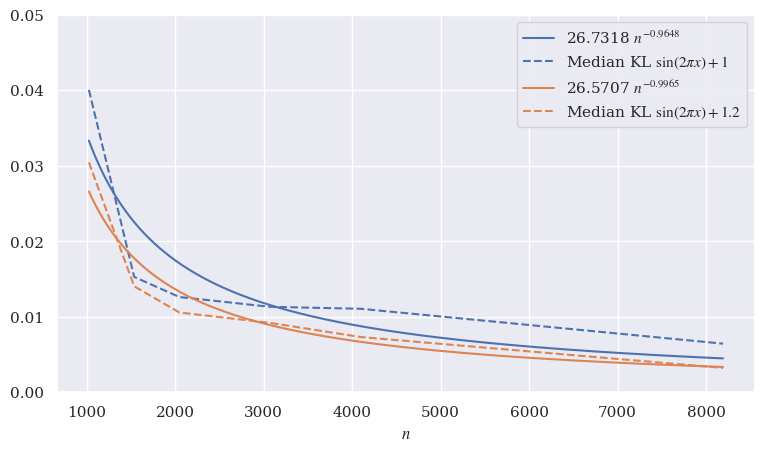

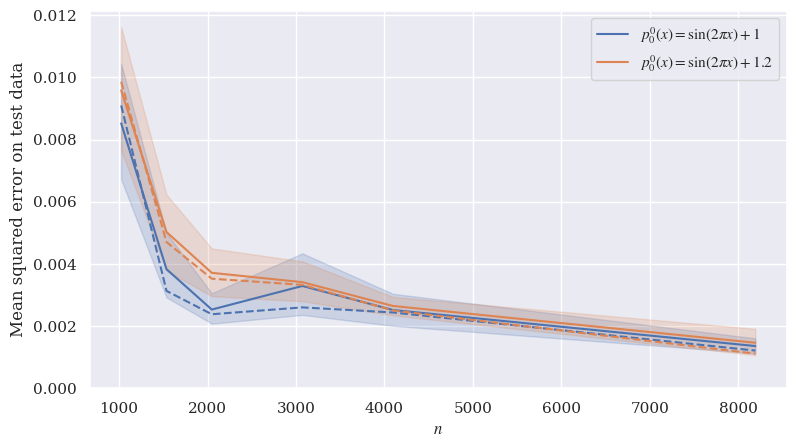

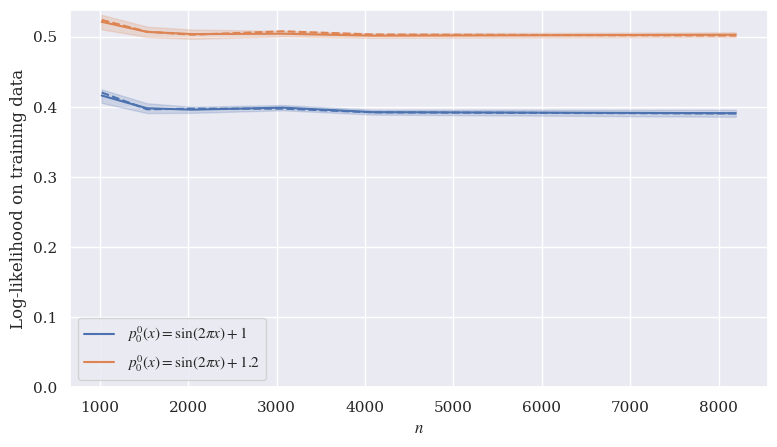

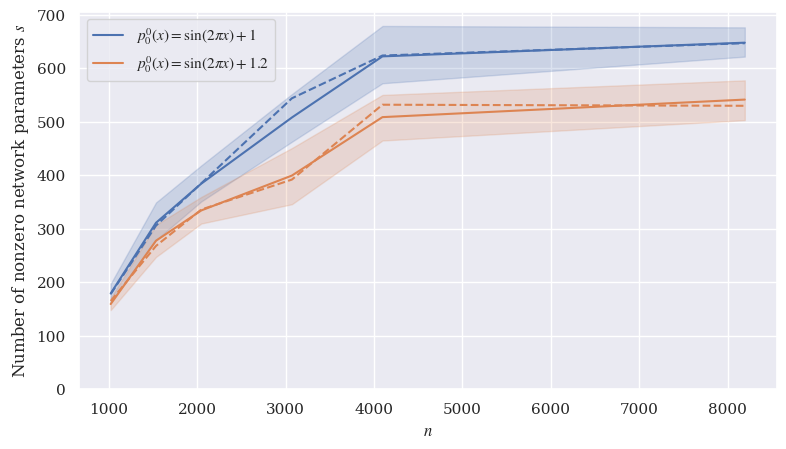

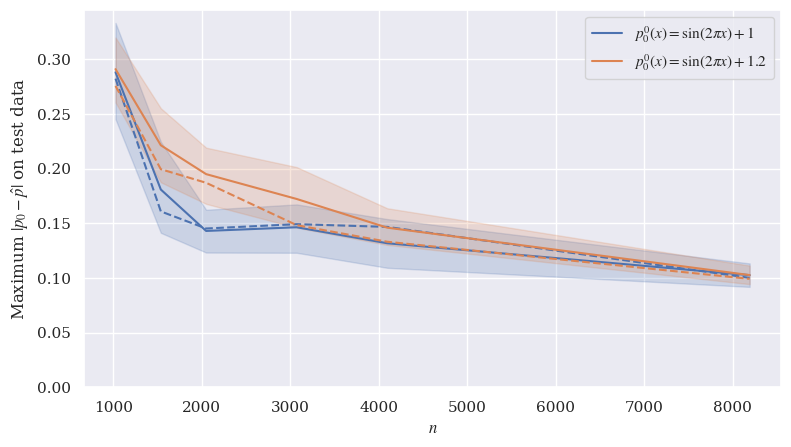

[[0.28237390356518277,
  0.1608677161424132,
  0.1452479315488311,
  0.1492135848119669,
  0.1467265662498597,
  0.10008518550534662],
 [0.2756760304854675,
  0.1994942083351609,
  0.18707943835179092,
  0.1483172362731262,
  0.1331243699477478,
  0.09916190881973369]]

## Reproducibility test

Euclidean distance between non- and normalized: 0.0


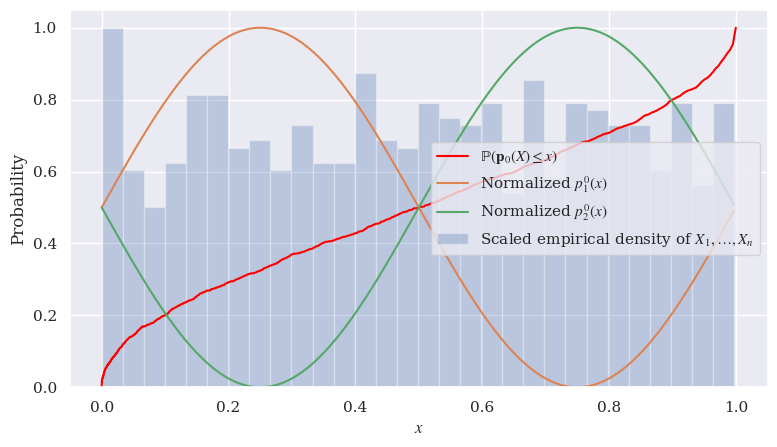

In [ ]:
sit = "sin(2*pi*x)+1+"
seed = 1
n = 1024
tr = SimulateData(sit, n, seed=seed)
tr.visualize(save_to_pdf=True)

[array([[-3.00065236e-04,  3.09568713e-05, -9.84414073e-05,
        -2.65166454e-06,  3.27896996e-04,  1.92030944e-04,
        -1.72825926e-03, -2.49058387e-04,  1.17529846e-04,
         1.12377747e-05, -1.02948521e-04, -1.48000385e-04,
         2.75341008e-05, -3.30205148e-05,  4.44848592e-06,
         8.78585735e-04, -5.80966444e-05, -9.15322307e-05,
        -1.50346503e-04,  1.91070831e-05, -1.37338968e-04,
         3.31439544e-04, -3.55876575e-04, -8.76588892e-05]], dtype=float32), array([ 9.14270349e-05,  4.01889556e-05,  5.54252620e-06,  5.20224785e-05,
       -2.53198868e-05,  5.80400192e-05,  2.57197389e-05, -1.27358464e-04,
        1.21783676e-04,  4.75503148e-05,  1.90086270e-04, -3.54982694e-06,
       -1.20699187e-05, -6.56485063e-05,  6.22404987e-05,  5.24235002e-05,
       -5.23458257e-05,  6.13332231e-05, -1.80712741e-05, -3.95595562e-05,
        8.31106663e-05,  6.63184328e-05,  1.24901699e-05,  4.03754966e-05],
      dtype=float32), array([[ 4.9416136e-05,  6.7025394e-

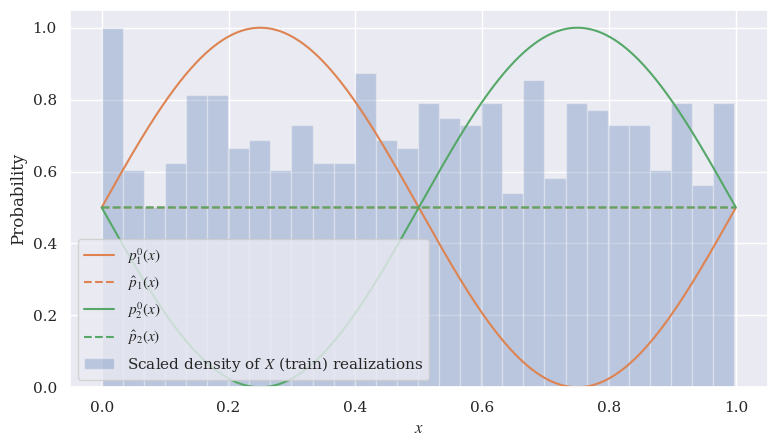

{'Biases > 0.001': 2,
 'Biases total': 74,
 'KL': 0.30796057,
 'KL_B=1.5': 0.3079605641018341,
 'LL': 0.6931473,
 'MSE': 0.12516049,
 'Pr. max difference': 0.4999999999589402,
 'Training LL': 0.6931473,
 'Weights > 0.001': 0,
 'Weights and biases > 1': 0,
 'Weights total': 1224,
 's': 2}

In [ ]:
va = SimulateData(sit, n * 10)
km = KerasModelStuff(tr, va)
km.train_network(seed=seed)
print(km.model.get_weights())
km.evaluate(va, save_to_pdf=True)

Euclidean distance between non- and normalized: 5.247236599067447


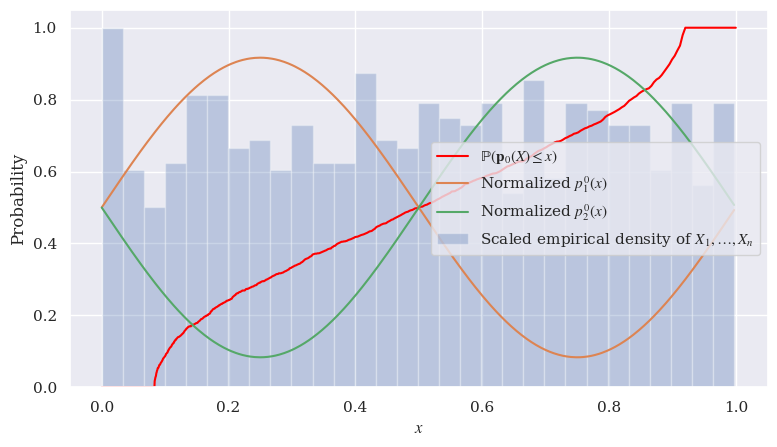

[array([[-6.3314861e-01,  6.3871855e-01,  1.6231994e-05, -2.4088246e-01,
        -4.8076749e-01, -1.1961525e-04,  8.0020869e-01, -2.2716442e-01,
        -6.4272831e-06,  4.0088415e-01,  3.2166380e-01,  4.0650374e-01,
         5.5253559e-01,  4.2006361e-01,  8.9152472e-06, -7.2547299e-01,
        -7.5482487e-05, -4.8503342e-01,  5.4850584e-01, -2.3847035e-05,
         5.5000156e-01, -6.0992944e-01, -6.6903609e-01, -4.5496041e-01]],
      dtype=float32), array([ 2.84239110e-02, -8.98843482e-02,  2.13404419e-05,  4.18803953e-02,
        6.68404326e-02,  1.24859380e-05,  5.06663397e-02,  8.92152190e-02,
        6.89760145e-06,  4.94939601e-03, -1.21246256e-01, -1.63458530e-02,
       -1.76581547e-01, -1.06880460e-02,  1.24950075e-05,  1.17184326e-01,
       -4.92785693e-06, -6.96029328e-03, -1.00119241e-01, -3.51712879e-06,
       -2.31178179e-02,  1.65604070e-01,  1.00054853e-01,  3.79505306e-02],
      dtype=float32), array([[-1.2453808e-04,  1.8823409e-04,  2.2382496e-04, ...,
        -

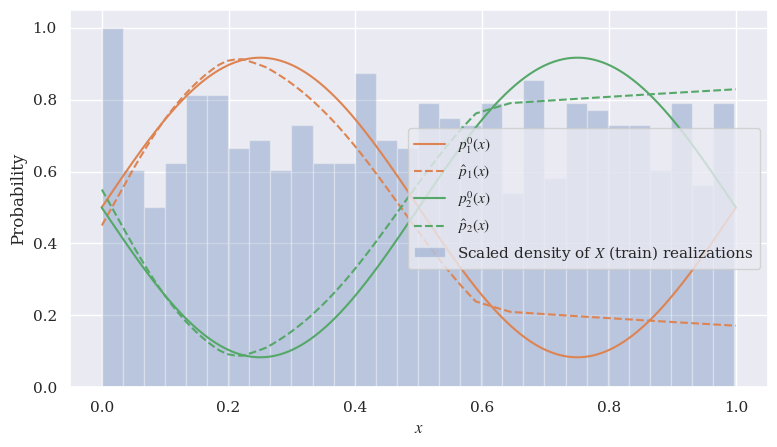

{'Biases > 0.001': 23,
 'Biases total': 74,
 'KL': 0.021761043,
 'KL_B=1.5': 0.021761043846659712,
 'LL': 0.5203601,
 'MSE': 0.0074367723,
 'Pr. max difference': 0.32847496937539244,
 'Training LL': 0.5280748,
 'Weights > 0.001': 116,
 'Weights and biases > 1': 1,
 'Weights total': 1224,
 's': 139}

In [ ]:
sit = "sin(2*pi*x)+1.2"
tr = SimulateData(sit, n, seed=seed)
tr.visualize(save_to_pdf=True)
va = SimulateData(sit, n * 10)
km = KerasModelStuff(tr, va)
km.train_network(seed=seed)
print(km.model.get_weights())
km.evaluate(va, save_to_pdf=True)

# (Temporarily) moved out of the way

In [ ]:
min_train_sets = 10
plt.figure()
# plt.title(f'Medians. KL lines are full, MSE lines dotted.')
median_list = []
for situation in all_results.keys():
    n_list = sorted(all_results[situation].keys())
    to_remove = []  # _very_ ugly
    kl_list = []
    mse_list = []
    for i, n in enumerate(n_list):
        kl = all_results[situation][n]['KL']
        kl_list.append(kl)
        mse = all_results[situation][n]['MSE']
        mse_list.append(mse)
        if len(kl) < min_train_sets:
            to_remove.append(i)
    for index in sorted(to_remove, reverse=True):
        del n_list[index]
        del kl_list[index]
        del mse_list[index]

    n_rep = [np.repeat(n, len(kl_list[i])) for i, n in enumerate(n_list)]
    pd_df = pd.DataFrame({
        'n': list(chain.from_iterable(n_rep)),
        'KL loss': list(chain.from_iterable(kl_list)),
        'MSE loss': list(chain.from_iterable(mse_list))
    })
    # print(pd_df)
    situation = '$\\' + situation.replace(c, ' ').replace('pi', '\pi') + '$'
    sns.lineplot(data=pd_df, x='n', y='KL loss', label="KL "+situation)
    sns.lineplot(data=pd_df, x='n', y='MSE loss', label="MSE "+situation,
                 color=plt.gca().lines[-1].get_color(), marker='o')
    plt.plot(n_list, [np.median(kl_inner) for kl_inner in kl_list], '--',
             color=plt.gca().lines[-1].get_color())
    plt.plot(n_list, [np.median(mse_inner) for mse_inner in mse_list], '--',
             color=plt.gca().lines[-1].get_color(), marker='o')

    median_list.append([np.median(kl_inner) for kl_inner in kl_list])

plt.title('')
plt.ylim(0, 0.05)
plt.xlabel("$n$")
plt.ylabel('')
plt.show()

# TODO: make less busy. Only consider the ironically unlabelled dotted lines for medians.

NameError: ignored

<Figure size 900x500 with 0 Axes>

In [ ]:
# This cell used KL_medians etc., now I store results in dicts

plt.figure(); plt.xlabel("$n$")
plt.title(f'KL full, MSE dotted')
for i, situation in enumerate(situation_list): 
    plt.plot(n_list, KL_medians[i], label=f"{situation}")
    plt.plot(n_list, MSE_medians[i], '--', color=plt.gca().lines[-1].get_color())
plt.legend()
plt.plot

KL_med_df = pd.DataFrame(np.transpose(KL_medians.round(5)))
KL_med_df.columns = [f'{s}' for s in situation_list]
KL_med_df.index = [f'{n}' for n in n_list]

print(KL_med_df)

# plt.figure(); plt.xlabel("$n$")
# plt.title(f'MSE')
# for i, situation in enumerate(situation_list): 
#     plt.plot(n_list, MSE_medians[i], label=f"{situation}")
#     # plt.plot(n_list, MSE_medians[i], '--', color=plt.gca().lines[-1].get_color())
# plt.legend()
# plt.plot

MSE_med_df = pd.DataFrame(np.transpose(MSE_medians.round(5)))
MSE_med_df.columns = [f'{s}' for s in situation_list]
MSE_med_df.index = [f'{n}' for n in n_list]

# TODO: sth nicer, use local.py

In [ ]:
df = pd.DataFrame(KL_meds)
df.columns = [f'${s}$' for s in situation_list]
df.index = [f'$n={n}$' for n in n_list]
print(df.to_latex(escape=False))
df

In [ ]:
In sample_and_funcs:
    
    elif situation == "3":
        desc = f"Situation 3: sampling {n} X_i ~ a mixture of normals. K = 2."
        mu = [.4, .8]
        sigma = [.5, .1]
        pY = [.5, .5]

        def p(x):
            return sum([ss.norm(mu[i], sigma[i]).pdf(x) * pY[i] for i in range(len(mu))])

        X = unif_rejection_sampling(p, n, seed)
        funcs = [ss.norm(mu[i], sigma[i]).pdf for i in range(len(mu))]
    elif situation == "4":
        desc = f"Situation 4: sampling {n} X_i ~ 1D uniform. f1(X)=f2(X). K = 2."
        X = np.random.uniform(size=n)
        def f1(X): return (1 + X) / 3
        def f2(X): return f1(X)
        funcs = [f1, f2]
    elif "6." in situation:
        # TODO: handle above?
        K_str = situation.split('.')[1]
        if K_str != "":
            K = int(K_str)
        else:
            K = 3
            print("K not specified, just setting it to 3.")
        desc = f"Situation 6: sampling {n} X_i ~ 1D uniform. f_k(X) = a normal. K = {K}."
        X = np.random.uniform(size=n)
        funcs = []
        for k in range(K):
            funcs.append(lambda x, k=k: ss.norm(k / K, 0.5 / K).pdf(x))
    elif situation == "7":
        desc = f"Situation 7: sampling {n} X_i ~ 1D uniform. f1(X) = TODO. K = 2."
        X = np.random.uniform(size=n)
        beta = 4
        def f1(X): return 1 / (1 + np.power(X / (1 - X), - 1 * beta))
        def f2(X): return 1 - f1(X)
        funcs = [f1, f2]


In visualize_tf:
    elif X_test.shape[1] == 2:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        n, k = Y_prob_test.shape
        subset = np.random.choice(n, 200)
        step = int(n / 200)
        subset = list(np.argsort(X_test[:, 0]))[::step]
        # MAYDO: seperate plots for both classes
        for i in range(k):
            ax.scatter(X_test[subset, 0], X_test[subset, 1], Y_test_pred[subset, i],
                       label=f'$\hat{{p}}_{i+1}(\mathbf{{x}})$')
            ax.scatter(X_test[subset, 0], X_test[subset, 1], Y_prob_test[subset, i],
                       label=f'$p^0_{i+1}(\mathbf{{x}})$', marker='^')

        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.legend()
        plt.show()
        plt.show()
    else:
        print("Not visualizing since X.ndim > 2")